In [1]:
import pymupdf
import imageio.v3 as iio
import numpy as np
import skimage as ski
import skimage.transform as sktransform

def pdf_to_image(pdf_path, dpi=300):
    doc = pymupdf.open('pdf_path')
    page = doc.load_page(0)
    pixmap = page.get_pixmap(dpi=dpi)
    return pixmap

def rgb_to_gray(im):
    return np.round(255 - np.dot(im[...,:3], [0.2989, 0.5870, 0.1140]))

new_shape = (8, 8)
def scale_image(image):
    return sktransform.resize(image, new_shape, anti_aliasing=True)
    

In [139]:
from skimage.measure import label, regionprops
from matplotlib import pyplot as plt
import os
import random

def get_connected_components(im):
    return regionprops(label(im))

def refine_region(region):
    region = np.array(region, dtype=np.float32)
    if region.shape[0] > region.shape[1]:
        region = np.pad(region, ((0, 0), (0, region.shape[0] - region.shape[1])), 'constant', constant_values=0)
    elif region.shape[0] < region.shape[1]:
        region = np.pad(region, ((0, region.shape[1] - region.shape[0]), (0, 0)), 'constant', constant_values=0)
    region = scale_image(region)
    region = region / region.max()
    region = np.sqrt(2 * region - region**2)
    region = np.round(region * 255).astype(np.uint8)
    return region

def difference(im1, im2):
    return np.sum((im1 - im2) ** 2) / (im1.shape[0] * im1.shape[1]) / 255

all_chars = []

def process_image(image_path):
    image = iio.imread(image_path)
    image = rgb_to_gray(image)
    regionprops = get_connected_components(image)
    regions = [refine_region(region.image) for region in regionprops]
    for region in regions:
        check = True
        for diff_region in all_chars:
            if difference(region, diff_region) < 0.1:
                check = False
                break
        if check:
            all_chars.append(region)

def process_directory(directory_path, filenames):
    files = os.listdir(directory_path)
    random.shuffle(files)
    for i, filename in enumerate(files):
        if filename in filenames:
            process_image(os.path.join(directory_path, filename))
            print(f"{i}: Processed {filename}, {len(all_chars)} characters found.")

In [ ]:
train_data = open('.\\..\\dataset\\im2latex_train.lst').readlines()
filenames = set()
for i, filename in enumerate(train_data):
   filenames.add(filename.strip().split(' ')[1] + '.png')

process_directory('F:\\formula_images\\formula_images', filenames)

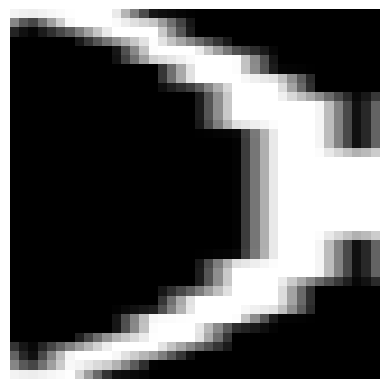

In [13]:
# display images

def display_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

display_image(all_chars[2])

In [ ]:
import pandas as pd
import datasets

data_dict = {}

for i, char in enumerate(all_chars):
    data_dict[i] = np.array(char).flatten().tolist()

datasets.Dataset.save_to_disk(
    datasets.Dataset.from_dict({'image': data_dict.values()}),
    './all_characters'
)

d:\miniconda\envs\conda-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Saving the dataset (1/1 shards): 100%|██████████| 5938/5938 [00:00<00:00, 143153.93 examples/s]
